<a href="https://colab.research.google.com/github/hiydavid/tfdev_learning/blob/main/ZTM/notebooks/tfdev_05_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Transfer Learning Fine Tuning

In this notebook we'll:

* Introducing transfer learning fine-tuning
* Introduce the Keras functional API
* Use a small dataset to experiment faster
* Data augmentation
* Running a series of experiments on our Food Vision data
* Introduce the ModelCheckpoint callback to save intermediate training results

# Import Helper Functions

In [1]:
# get prebuilt helper function 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-30 05:25:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-30 05:25:50 (40.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# import helper functions
from helper_functions import (
    create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
)

# Get Data

In [3]:
# get data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-03-30 05:25:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   207MB/s    in 0.8s    

2022-03-30 05:25:57 (207 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# check out how many images and subdirectories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
# create training / testing paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [6]:
# load data using image_dataset_from_directory
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
# check output, see that it is batches of data
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# check class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# check 1 sample from 1 batch
for images, labels in train_data_10_percent.take(1):
    print(images[0], labels[0])

tf.Tensor(
[[[ 99.64286    43.642857   26.642857 ]
  [100.97449    44.97449    27.97449  ]
  [100.928566   45.57143    28.357143 ]
  ...
  [159.89227   126.61673    96.62703  ]
  [ 94.95916    56.82138    35.295906 ]
  [ 81.15787    39.15787    23.15787  ]]

 [[ 97.7398     41.739796   24.739796 ]
  [ 99.005104   43.005104   26.005102 ]
  [100.77041    45.41327    28.19898  ]
  ...
  [ 66.59681    30.16819     2.4233613]
  [ 69.87256    28.938858    9.081755 ]
  [ 82.2502     36.43897    21.444077 ]]

 [[103.57143    47.142857   32.357143 ]
  [100.07143    44.071426   29.071428 ]
  [ 98.26021    42.260204   27.260204 ]
  ...
  [ 81.9692     41.254803   14.326318 ]
  [ 82.32657    36.19899    12.724532 ]
  [ 81.54602    32.331734   14.0460205]]

 ...

 [[ 76.994316   40.275       7.9588323]
  [149.61705   107.10181    68.45904  ]
  [172.38275   123.14299    74.02571  ]
  ...
  [124.05082   110.09673    60.07132  ]
  [125.89776   111.46923    62.18359  ]
  [136.40817   121.979645   74.55

# Build Model with Functional API

In [10]:
# build functional API with keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# freeze the base model
base_model.trainable = False

# create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# pass the input
x = base_model(inputs)

# average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=int(0.25 * len(test_data_10_percent)), 
    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")]
)

16719872/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220330-053425
Epoch 1/5
24/24 [==============================] - 28s 461ms/step - loss: 1.9567 - accuracy: 0.3480 - val_loss: 1.4140 - val_accuracy: 0.6809
Epoch 2/5
24/24 [==============================] - 9s 361ms/step - loss: 1.1705 - accuracy: 0.7387 - val_loss: 0.9610 - val_accuracy: 0.7796
Epoch 3/5
24/24 [==============================] - 9s 358ms/step - loss: 0.8596 - accuracy: 0.7947 - val_loss: 0.8021 - val_accuracy: 0.7977
Epoch 4/5
24/24 [==============================] - 9s 359ms/step - loss: 0.6890 - accuracy: 0.8440 - val_loss: 0.6937 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 9s 359ms/step - loss: 0.5976 - accuracy: 0.8653 - val_loss: 0.6407 - val_accuracy: 0.8289


In [12]:
# evaluate
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 138ms/step - loss: 0.6205 - accuracy: 0.8372


[0.6205161809921265, 0.8371999859809875]

In [14]:
# check layers and name
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
# view base model summary
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
# summary of model_0
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


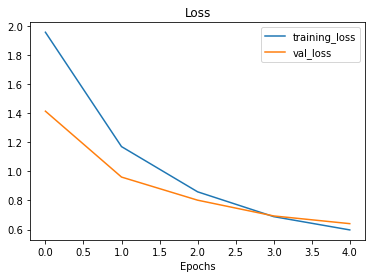

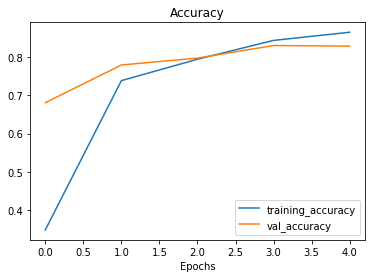

In [17]:
# check training curves
plot_loss_curves(history_10_percent)